In [1]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/My Drive/Histopathology data/converted.zip" "converted.zip"

In [3]:
!unzip -q converted.zip

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [5]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [6]:
batch_size_train = 5 # We use a small batch size here for training
batch_size_test = 10 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('converted/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: BACK


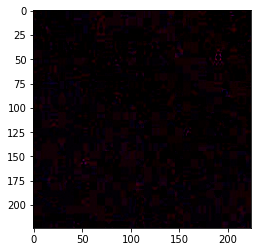

In [7]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class SeparableConv(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.dwc = nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size, stride, padding, dilation, groups=input_channel, bias=bias),
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, 1, 1, bias=bias)
        )
    
    def forward(self, X):
        return self.dwc(X)

class Block(nn.Module):
    def __init__(self, input_channel, out_channel, reps, strides=1, relu=True, grow_first=True):
        super().__init__()
        if out_channel != input_channel or strides!=1:
            self.skipConnection = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, 1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.skipConnection = None
        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = input_channel
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))
            filters = out_channel
        
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))

        if not relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        X = self.rep(input)

        if self.skipConnection:
            skip = self.skipConnection(input)
        else:
            skip = input
        
        X += skip
        return X

class Xception(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.relu = nn.ReLU(inplace=True)

        self.initBlock = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1=Block(64,128,2,2,relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block5=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block6=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block7=Block(728,728,3,1,relu=True,grow_first=True)

        #self.block8=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block9=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block10=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block11=Block(728,728,3,1,relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,relu=True,grow_first=False)

        self.conv3 = SeparableConv(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, self.n_classes)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.initBlock(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        #x = self.block5(x)
        #x = self.block6(x)
        #x = self.block7(x)
        #x = self.block8(x)
        #x = self.block9(x)
        #x = self.block10(x)
        #x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [9]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Xception(input_channel=3, n_classes=9).to(device)
learning_rate = 0.0005
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the 
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by 
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [12]:
import os.path
from os import path

num_epoch = 90
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("Xception9categoriesmodel.pth"):
        os.remove("Xception9categoriesmodel.pth")

      torch.save(model.state_dict(), 'Xception9categoriesmodel.pth')
      acc=acct
    train_loss.append(tl)
    test_loss.append(stl)
    accuracy_test.append(acct)

!cp Xception9categoriesmodel.pth '/content/drive/My Drive/SGD/'

print(acc)


1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 1.0346

Test: Average loss: 0.5469, Accuracy: 4331/5400 (80.20%)

2


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.6786

Test: Average loss: 0.5844, Accuracy: 4351/5400 (80.57%)

3


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.5332

Test: Average loss: 0.3206, Accuracy: 4829/5400 (89.43%)

4


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.4373

Test: Average loss: 0.2928, Accuracy: 4895/5400 (90.65%)

5


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3640

Test: Average loss: 0.2614, Accuracy: 4965/5400 (91.94%)

6


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.3122

Test: Average loss: 0.2184, Accuracy: 5003/5400 (92.65%)

7


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2898

Test: Average loss: 0.2328, Accuracy: 4991/5400 (92.43%)

8


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2423

Test: Average loss: 0.2005, Accuracy: 5055/5400 (93.61%)

9


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2400

Test: Average loss: 0.1757, Accuracy: 5069/5400 (93.87%)

10


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.2158

Test: Average loss: 0.1712, Accuracy: 5103/5400 (94.50%)

11


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1931

Test: Average loss: 0.1970, Accuracy: 5028/5400 (93.11%)

12


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1735

Test: Average loss: 0.1324, Accuracy: 5194/5400 (96.19%)

13


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1643

Test: Average loss: 0.2177, Accuracy: 5010/5400 (92.78%)

14


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1523

Test: Average loss: 0.1205, Accuracy: 5204/5400 (96.37%)

15


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1431

Test: Average loss: 0.1755, Accuracy: 5086/5400 (94.19%)

16


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1311

Test: Average loss: 0.1894, Accuracy: 5098/5400 (94.41%)

17


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1238

Test: Average loss: 0.0984, Accuracy: 5241/5400 (97.06%)

18


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1091

Test: Average loss: 0.1105, Accuracy: 5215/5400 (96.57%)

19


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1003

Test: Average loss: 0.1801, Accuracy: 5060/5400 (93.70%)

20


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.1084

Test: Average loss: 0.1403, Accuracy: 5162/5400 (95.59%)

21


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0937

Test: Average loss: 0.0753, Accuracy: 5272/5400 (97.63%)

22


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0885

Test: Average loss: 0.1001, Accuracy: 5230/5400 (96.85%)

23


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0843

Test: Average loss: 0.0810, Accuracy: 5262/5400 (97.44%)

24


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0869

Test: Average loss: 0.0883, Accuracy: 5259/5400 (97.39%)

25


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0823

Test: Average loss: 0.1101, Accuracy: 5217/5400 (96.61%)

26


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0692

Test: Average loss: 0.1036, Accuracy: 5200/5400 (96.30%)

27


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0602

Test: Average loss: 0.1559, Accuracy: 5142/5400 (95.22%)

28


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0613

Test: Average loss: 0.1394, Accuracy: 5165/5400 (95.65%)

29


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0611

Test: Average loss: 0.0835, Accuracy: 5272/5400 (97.63%)

30


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0548

Test: Average loss: 0.0977, Accuracy: 5232/5400 (96.89%)

31


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0496

Test: Average loss: 0.0789, Accuracy: 5271/5400 (97.61%)

32


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0512

Test: Average loss: 0.0609, Accuracy: 5301/5400 (98.17%)

33


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0501

Test: Average loss: 0.0991, Accuracy: 5235/5400 (96.94%)

34


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0432

Test: Average loss: 0.0944, Accuracy: 5237/5400 (96.98%)

35


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0534

Test: Average loss: 0.0724, Accuracy: 5280/5400 (97.78%)

36


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0455

Test: Average loss: 0.0797, Accuracy: 5287/5400 (97.91%)

37


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0425

Test: Average loss: 0.0840, Accuracy: 5254/5400 (97.30%)

38


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0394

Test: Average loss: 0.0800, Accuracy: 5277/5400 (97.72%)

39


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0454

Test: Average loss: 0.1522, Accuracy: 5161/5400 (95.57%)

40


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0387

Test: Average loss: 0.0847, Accuracy: 5273/5400 (97.65%)

41


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0300

Test: Average loss: 0.0890, Accuracy: 5263/5400 (97.46%)

42


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0335

Test: Average loss: 0.0914, Accuracy: 5258/5400 (97.37%)

43


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0328

Test: Average loss: 0.1640, Accuracy: 5161/5400 (95.57%)

44


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0327

Test: Average loss: 0.0813, Accuracy: 5263/5400 (97.46%)

45


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0357

Test: Average loss: 0.1131, Accuracy: 5220/5400 (96.67%)

46


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0256

Test: Average loss: 0.0949, Accuracy: 5270/5400 (97.59%)

47


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0293

Test: Average loss: 0.1270, Accuracy: 5216/5400 (96.59%)

48


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0275

Test: Average loss: 0.0758, Accuracy: 5287/5400 (97.91%)

49


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0260

Test: Average loss: 0.0655, Accuracy: 5291/5400 (97.98%)

50


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0262

Test: Average loss: 0.0798, Accuracy: 5271/5400 (97.61%)

51


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0288

Test: Average loss: 0.0908, Accuracy: 5246/5400 (97.15%)

52


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0333

Test: Average loss: 0.0682, Accuracy: 5300/5400 (98.15%)

53


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0349

Test: Average loss: 0.0735, Accuracy: 5288/5400 (97.93%)

54


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0336

Test: Average loss: 0.0847, Accuracy: 5267/5400 (97.54%)

55


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0295

Test: Average loss: 0.0855, Accuracy: 5256/5400 (97.33%)

56


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0230

Test: Average loss: 0.0647, Accuracy: 5300/5400 (98.15%)

57


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0253

Test: Average loss: 0.0746, Accuracy: 5276/5400 (97.70%)

58


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0131

Test: Average loss: 0.0661, Accuracy: 5299/5400 (98.13%)

59


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0192

Test: Average loss: 0.0834, Accuracy: 5283/5400 (97.83%)

60


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0263

Test: Average loss: 0.0658, Accuracy: 5308/5400 (98.30%)

61


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0193

Test: Average loss: 0.1254, Accuracy: 5165/5400 (95.65%)

62


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0220

Test: Average loss: 0.0822, Accuracy: 5268/5400 (97.56%)

63


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0161

Test: Average loss: 0.0661, Accuracy: 5291/5400 (97.98%)

64


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0137

Test: Average loss: 0.0750, Accuracy: 5281/5400 (97.80%)

65


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0224

Test: Average loss: 0.0636, Accuracy: 5298/5400 (98.11%)

66


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0199

Test: Average loss: 0.0703, Accuracy: 5284/5400 (97.85%)

67


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0154

Test: Average loss: 0.0818, Accuracy: 5266/5400 (97.52%)

68


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0245

Test: Average loss: 0.0839, Accuracy: 5257/5400 (97.35%)

69


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0193

Test: Average loss: 0.0983, Accuracy: 5246/5400 (97.15%)

70


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0192

Test: Average loss: 0.0592, Accuracy: 5312/5400 (98.37%)

71


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0155

Test: Average loss: 0.0562, Accuracy: 5315/5400 (98.43%)

72


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0147

Test: Average loss: 0.0912, Accuracy: 5252/5400 (97.26%)

73


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0170

Test: Average loss: 0.0582, Accuracy: 5307/5400 (98.28%)

74


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0116

Test: Average loss: 0.0792, Accuracy: 5292/5400 (98.00%)

75


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0139

Test: Average loss: 0.0623, Accuracy: 5310/5400 (98.33%)

76


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0179

Test: Average loss: 0.0838, Accuracy: 5280/5400 (97.78%)

77


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0110

Test: Average loss: 0.0645, Accuracy: 5319/5400 (98.50%)

78


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0106

Test: Average loss: 0.0615, Accuracy: 5322/5400 (98.56%)

79


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0179

Test: Average loss: 0.0770, Accuracy: 5290/5400 (97.96%)

80


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0116

Test: Average loss: 0.0623, Accuracy: 5305/5400 (98.24%)

81


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0102

Test: Average loss: 0.0669, Accuracy: 5307/5400 (98.28%)

82


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0152

Test: Average loss: 0.0817, Accuracy: 5262/5400 (97.44%)

83


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0111

Test: Average loss: 0.0593, Accuracy: 5316/5400 (98.44%)

84


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0091

Test: Average loss: 0.0689, Accuracy: 5316/5400 (98.44%)

85


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0186

Test: Average loss: 0.0849, Accuracy: 5280/5400 (97.78%)

86


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0134

Test: Average loss: 0.0668, Accuracy: 5309/5400 (98.31%)

87


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0085

Test: Average loss: 0.0803, Accuracy: 5293/5400 (98.02%)

88


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0093

Test: Average loss: 0.0736, Accuracy: 5291/5400 (97.98%)

89


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0086

Test: Average loss: 0.0683, Accuracy: 5297/5400 (98.09%)

90


  0%|          | 0/2520 [00:00<?, ?it/s]

Train: Average loss: 0.0087

Test: Average loss: 0.0622, Accuracy: 5308/5400 (98.30%)

98.55555555555556


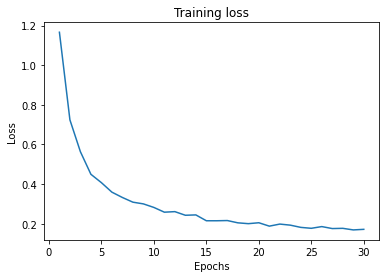

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,train_loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

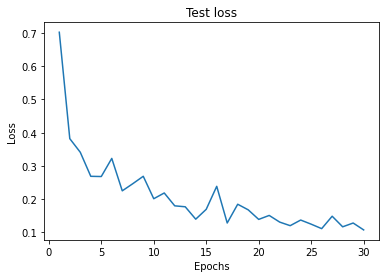

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

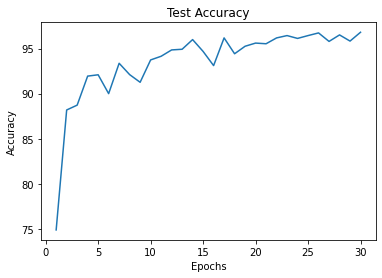

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()